In [1]:
from brian2 import *
#import numpy as np
# from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

Excitatory Neurons:
$$ \tau_m^+ \frac{\phi^P(\vec r, t+\Delta t)  - \phi^p(\vec r, t)}{\Delta t} + \phi^P(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + \Sigma_{\vec r'}w^-(\vec r - \vec r')s^-(\vec r', t - \tau_s^-) + a^+(\vec r)[1 + \alpha E^P \bullet V(t)] + \zeta^P(\vec r, t)  $$

Inhibitory Neurons:
$$ \tau_m^+ \frac{\phi^-(\vec r, t+\Delta t)  - \phi^-(\vec r, t)}{\Delta t} + \phi^-(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + a^-(t) + \zeta^-(\vec r, t)  $$

Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

$$ a^+(\vec r) = \begin{cases}
                -a_{min}^+ + (a^+_{max} - a^+_{min})^{\frac{1 + cos(\pi \rho /\rho_{a^+})}{2}}& \text{; } \rho < \rho a+\\
                a_{min}^+          & \text{; } \rho \geq \rho a+.
         \end{cases}
                $$

$$ a^-(t) = a_{mag}^- - a_{th}^-cos(t\pi ft + \psi_0)  $$

$$ \rho = \frac{\sqrt{(x - \frac{n+1/2}{2}^2 + (y - \frac{n+1}{2}^2)}}{n/2} $$

In [2]:
start_scope() # creat a new scope

# Parameters
N = 232 * 232 # Neurons per population
N = 10 * 10

tau_m_plus = 40*ms # Exc. membrane time constant
tau_m_minus = 20*ms # Inh. membrane time constant
tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
tau_s_minus = 2*ms # Inh. synaptic delay
a_max_plus = 2 # Exc. drive maximum
a_min_plus = 0.8 # Exc. drive minimum
rho_a_plus = 1.2 # Exc. drive scaled speed
a_mag_minus = 0.72 # Inh. drive magnitude
a_th_minus = 0.2 # Inh. drive theta amplitude
f = 8*hertz # Inh. drive theta frequency
w_mag_plus = 0.2 # Exc. synaptic strength
r_w_plus = 6 # Exc. synaptic spread
w_mag_minus = 2.8 # Inh. synaptic strength
r_w_minus = 12 # Inh. synaptic distance
xi = 3 # Exc. synaptic shift
alpha = 0.25*second/metre # Exc. velocity gain
var_zeta_P = 0.002**2 # Exc. noise magnitude
var_zeta_I = 0.002**2 # Inh. noise magnitude


duration = 1000*ms


In [3]:
defaultclock.dt = 0.1*ms

### Velocity Inputs (Based on Rat Trajectory):
Two options:
1. Simulate the inputs (as done by Mittal & Narayanan, 2021)
2. Differentiate rat trajectories (as done by Burak & Fiete, 2009 and used in Kang & DeWeese 2019)


In [4]:
@check_units(dir = metre, V = metre/second, result= metre/second)
def dot_product(dir, V):
    product = dot(dir, V) / metre
    print(product)
    return product


In [5]:
dot_product([1, 0] * metre, [1, 0]*metre/second)

1. m/s


1. * metre / second

In [14]:
eqns_exc = '''

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir(i), V(t)))/tau_m_plus : 1

'''
""" 
eqns_exc = '''

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus/tau_m_plus : 1

'''  """

eqns_inh = '''

dv/dt = -(v - a_minus)/tau_m_minus + var_zeta_I*xi*tau_m_minus**-0.5 : 1
a_minus = a_mag_minus - a_th_minus*cos(2*pi*f*t): 1

'''

reset = '''
v = 0
'''


In [15]:

#@check_units(i = 1, result = [metre for x in range(len(i))])
@check_units(i = 1, N = 1, result = metre)
def location_x(i, N):
    x = i % N
    return x * metre

@check_units(i = 1, N = 1, result = metre)
def location_y(i, N):
    y = i // N
    return y * metre

@check_units(x = 1, y = 1, N = 1, result = metre)
def rho(x, y, N):

    value = sqrt(((x - ((N+1)/2))**2 + (y - ((N+1)/2))**2)/(N/2))

    return value * metre

@check_units(rho = 1, result = 1)
def a_plus(rho):

    value = a_min_plus * ones_like(rho)
    for i in range(len(rho)):
        if rho[i] < rho_a_plus:
            value[i] = (a_max_plus - a_min_plus) * (1 - cos(pi*rho[i]/rho_a_plus))
    return value

@check_units(x = 1, y = 1, result = metre)
def dir_array(x, y, N):
    x_array = x * ones(N)
    y_array = y * ones(N)

    return column_stack((x_array, y_array)) * metre

In [16]:
# Neural Populations

## North
P_n = NeuronGroup(N, eqns_exc, threshold='v > 1', reset=reset, method='euler')
P_n.add_attribute('x')
P_n.add_attribute('y')
P_n.add_attribute('dir')
P_n.add_attribute('rho')
P_n.add_attribute('a_plus')
P_n.add_attribute('r')

# (P_n.x, P_n.y) = 'location(i)'
P_n.x = location_x(P_n.i[:], sqrt(P_n.N))
P_n.y = location_y(P_n.i[:], sqrt(P_n.N))
""" P_n.x = 'i % 232' # will assign x-values from 0 to 231 repeatedly
P_n.y = 'i//232' # will assign y-value 0 to first 232 cells and so on
P_n.rho = 'sqrt((x - ((n+1)/2))**2 + (y - ((n+1)/2))**2)/(N/2)'
P_n.a_plus = 'where(rho < rho_a_plus, a_min_plus + (a_max_plus - a_min_plus)*(1 - cos(pi*rho/rho_a_plus)), a_min_plus)'

"""
# P_n.dir = [0, 1] * metre # North
P_n.dir = dir_array(0, 1, P_n.N)
P_n.rho = rho(P_n.x/metre, P_n.y/metre, sqrt(P_n.N))
P_n.a_plus = a_plus(P_n.rho[:]/metre)
P_n.v = 'rand()'

## South
P_s = NeuronGroup(N, eqns_exc, threshold='v > 1', reset=reset, method='euler')
P_s.add_attribute('x')
P_s.add_attribute('y')
P_s.add_attribute('dir')
P_s.add_attribute('rho')
P_s.add_attribute('a_plus')
P_s.x = location_x(P_s.i[:], sqrt(P_s.N))
P_s.y = location_y(P_s.i[:], sqrt(P_s.N))
P_s.dir = dir_array(0, -1, P_s.N)
P_s.rho = rho(P_s.x/metre, P_s.y/metre, sqrt(P_s.N))
P_s.a_plus = a_plus(P_s.rho[:]/metre)
P_s.v = 'rand()'


## East
P_e = NeuronGroup(N, eqns_exc, threshold='v > 1', reset=reset, method='euler')
P_e.add_attribute('x')
P_e.add_attribute('y')
P_e.add_attribute('dir')
P_e.add_attribute('rho')
P_e.add_attribute('a_plus')
P_e.x = location_x(P_e.i[:], sqrt(P_e.N))
P_e.y = location_y(P_e.i[:], sqrt(P_e.N))
P_e.dir = dir_array(1, 0, P_e.N)
P_e.rho = rho(P_e.x/metre, P_e.y/metre, sqrt(P_e.N))
P_e.a_plus = a_plus(P_e.rho[:]/metre)
P_e.v = 'rand()'


## West
P_w = NeuronGroup(N, eqns_exc, threshold='v > 1', reset=reset, method='euler' )
P_w.add_attribute('x')
P_w.add_attribute('y')
P_w.add_attribute('dir')
P_w.add_attribute('rho')
P_w.add_attribute('a_plus')
P_w.x = location_x(P_w.i[:], sqrt(P_w.N))
P_w.y = location_y(P_w.i[:], sqrt(P_w.N))
P_w.dir = dir_array(-1, 0, P_w.N)
P_w.rho = rho(P_w.x/metre, P_w.y/metre, sqrt(P_w.N))
P_w.a_plus = a_plus(P_w.rho[:]/metre)
P_w.v = 'rand()'


## Inhibitory
P_i = NeuronGroup(N, eqns_inh, threshold='v > 1', reset=reset, method='euler' )
P_i.add_attribute('x')
P_i.add_attribute('y')

P_i.x = location_x(P_i.i[:], sqrt(P_i.N))
P_i.y = location_y(P_i.i[:], sqrt(P_i.N))
#P_i.a_minus = 'a_mag_minus - a_th_minus*cos(2*pi*f'
P_i.v = 'rand()'

M_n = SpikeMonitor(P_n)
M_s = SpikeMonitor(P_s)
M_e = SpikeMonitor(P_e)
M_w = SpikeMonitor(P_w)



In [13]:
#P_n.variables = core.variables.Variables(P_n)
P_n.variables.add_array('dir',size=(N, 2))

P_n.variables.

KeyError: 'The name "dir" is already present in the variables dictionary.'

In [11]:
P_n.dir = 'dir'

In [33]:
P_n.dir

'dir'

In [32]:
P_n.v

<neurongroup_5.v: array([0.86268869, 0.48407928, 0.14471641, 0.37155971, 0.5822013 ,
       0.67128042, 0.2366461 , 0.85292226, 0.06101436, 0.15732731,
       0.26432431, 0.91955611, 0.44271645, 0.36113712, 0.39110667,
       0.19250899, 0.76765426, 0.18391257, 0.87498207, 0.026024  ,
       0.78456027, 0.92261195, 0.44510822, 0.07545942, 0.78791203,
       0.21582774, 0.6645665 , 0.01289544, 0.754829  , 0.46040694,
       0.36189954, 0.7455131 , 0.81461808, 0.91064511, 0.83023368,
       0.08261177, 0.90766438, 0.07426259, 0.52416396, 0.70316619,
       0.99720497, 0.64534895, 0.69871266, 0.98610272, 0.99640544,
       0.70224014, 0.45394088, 0.37831833, 0.97117496, 0.72607786,
       0.32060012, 0.53821323, 0.21668   , 0.31013444, 0.82058841,
       0.44137687, 0.1387553 , 0.74029895, 0.24843106, 0.52283683,
       0.16623867, 0.19601897, 0.68307542, 0.30591115, 0.52203313,
       0.13945511, 0.14492772, 0.52353603, 0.22054157, 0.23733976,
       0.21039685, 0.11714953, 0.69563543, 0

In [38]:
NeuronGroup._create_variables()

AttributeError: type object 'NeuronGroup' has no attribute 'v'

In [16]:
type(P_n.i)

brian2.core.variables.VariableView

In [32]:
P_n.dir = core.variables.VariableView('dir', dir_array(1, 1, N), P_n)

In [33]:
print(P_n.dir)

AttributeError: 'Quantity' object has no attribute 'scalar'

In [34]:
print(P_n.dir[:])

dir


In [8]:
P_n.a_plus

array([0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 0.8       ,
       2.3853121 , 2.3853121 , 0.8       , 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 2.14950019,
       1.53209371, 1.53209371, 2.14950019, 0.8       , 0.8       ,
       0.8       , 0.8       , 0.8       , 2.3853121 , 1.53209371,
       0.38827569, 0.38827569, 1.53209371, 2.3853121 , 0.8       ,
       0.8       , 0.8       , 0.8       , 2.3853121 , 1.53209371,
       0.38827569, 0.38827569, 1.53209371, 2.3853121 , 0.8       ,
       0.8       , 0.8       , 0.8       , 0.8       , 2.14950

In [10]:
P_n.y[11]

1. * metre

In [11]:
P_n.dir

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [12]:
P_n.v

<neurongroup.v: array([0.08401089, 0.00136508, 0.08117963, 0.94168276, 0.35975934,
       0.13835455, 0.0824781 , 0.35966723, 0.30173545, 0.31542147,
       0.82496476, 0.06526878, 0.37628469, 0.96037999, 0.08078795,
       0.45629872, 0.56390911, 0.14314252, 0.39214235, 0.41787674,
       0.75091921, 0.83227413, 0.24739379, 0.88938459, 0.2105942 ,
       0.61536104, 0.24927783, 0.40035841, 0.6172876 , 0.69477684,
       0.58930248, 0.5085685 , 0.97769555, 0.30497273, 0.82796685,
       0.89392411, 0.99910267, 0.85452207, 0.910121  , 0.1715368 ,
       0.97287926, 0.56825631, 0.37826577, 0.36193436, 0.55747953,
       0.44812819, 0.70923631, 0.70486793, 0.03463203, 0.88877649,
       0.33627864, 0.18870535, 0.20762377, 0.71119547, 0.44595895,
       0.21042995, 0.33028883, 0.17681384, 0.34330348, 0.46057287,
       0.83444167, 0.54849088, 0.90853322, 0.28852257, 0.90224665,
       0.22506638, 0.38955042, 0.61485967, 0.36136951, 0.17692393,
       0.82846242, 0.15531898, 0.244861  , 0.6

### Synaptic Connectivity Matrix
Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

In [9]:
def exc_to_any_connectivity(N, dir, same_pop=False):
    """
    Sets up the connectivity matrix between two excitatory populations.
    N - number of neurons in each population
    dir - directional tuning vector of pre_synaptic population
    """
    connectivity = empty((N, N))
   # dir = eval(dir) # convert string representation to list
    for i in range(N): # looping over source neurons
        i_x = i % N
        i_y = i // N
        for j in range(N):
            j_x = j % N
            j_y = j % N

            if same_pop and i ==  j:
                connectivity[i, j] = 0
            else:
                connectivity[i, j] = w_mag_plus**(1 + cos(pi*sqrt((j_x - i_x - xi*dir[i, 0])**2 + (j_y - i_y - xi*dir[i, 1])**2)))

    return connectivity


def inh_to_exc_connectivity(N):
    """
    Sets up the connectivity matrix between two excitatory populations.
    N - number of neurons in each population
    dir - directional tuning vector of pre_synaptic population
    """
    connectivity = empty((N, N))

    for i in range(N): # looping over source neurons
        i_x = i % N
        i_y = i // N
        for j in range(N):
            j_x = j % N
            j_y = j % N

            connectivity[i, j] = w_mag_minus**(1 + cos(pi*sqrt((j_x - i_x)**2 + (j_y - i_y)**2)))

    return connectivity

In [10]:
S = [] # to store  the 25 synapse classes
exc_populations = [P_n, P_s, P_e, P_w]
all_populations = [P_n, P_s, P_e, P_w, P_i]
index = 0

# Set connections from excitatory to excitatory populations: (Total 16 iterations)
print("Setting up exc-->exc connections")
for src in exc_populations:
    print("Source population:", src.name)
    for trg in exc_populations:
        print("Target population:", trg)
        S.append(Synapses(src, trg, 'w: 1', on_pre='v_post += w'))
        if src == trg: # connection within the population     
            S[index].connect(condition='i!=j') # if connection within population, don't connect neurons to themselves
            # connectivity = exc_to_any_connectivity(N, src.dir, same_pop=True)
            # S[index].w = 'connectivity[i, j]'
            S[index].w = delete(exc_to_any_connectivity(N, src.dir/metre, same_pop=True).flatten(), range(0, N*N, N+1), 0) # deletes diagonal entries of connectivity before assigning it to weights
        else:
            S[index].connect() # if connections are between two populations, connect all neurons
            # connectivity = exc_to_any_connectivity(N, src.dir)
            # S[index].w = 'connectivity[i, j]'
            S[index].w = exc_to_any_connectivity(N, src.dir/metre).flatten()
        S[index].delay = 'tau_s_plus_plus'
        index += 1

# Set connections from excitatory to inhibitory population: (Total 4 iterations)
print("Setting up exc-->inh connections")
for i in exc_populations:
    S.append(Synapses(i, P_i, 'w:1', on_pre='v_post += w'))
    S[index].connect()
    # connectivity = exc_to_any_connectivity(N, src.dir)
    # S[index].w = 'connectivity[i, j]'
    S[index].w = exc_to_any_connectivity(N, src.dir/metre).flatten()
    S[index].delay = 'tau_s_minus_plus'
    index += 1    

# Set connections from inhibitory to excitatory neurons: (Total 4 iterations)
print("Setting up inh-->exc connections")
for i in exc_populations:
    S.append(Synapses(P_i, i, 'w:1', on_pre='v_post += w'))
    S[index].connect()
    # connectivity = inh_to_exc_connectivity(N)
    # S[index].w = 'connectivity[i, j]'
    S[index].w = inh_to_exc_connectivity(N).flatten()
    S[index].delay = 'tau_s_minus'
    index += 1

# The inhibitory population doesn't have recurrent connections within itself



Setting up exc-->exc connections
Source population: neurongroup
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')
Source population: neurongroup_1
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')
Source population: neurongroup_2
Target population: NeuronGroup(clock=Clock(dt=1

### Simulation Protocol
* Each neuron initialised to a random potential between 0 & 1
* 500 timesteps without velocity input to generate grid like pattern
* 3 evolutions of timesteps with constant velocity input of 0.5m/sec at angles $\pi/2 - \pi/5, 2\pi/5, and \pi/4$ successively.
* Evolve the network for 4 laps without idle periods. (What is a lap?)

Where to get the velocity inputs from?

### Plot grid cell activity

Ways to do this:
1. Bin spiking activity in some time window and plot as heatmap on top of neural sheet (for any particular timewindow)
2. 

[[-0.01518193  0.02709771]
 [-0.04320254 -0.00876418]
 [ 0.0035412  -0.003743  ]
 ...
 [ 0.59448003 -0.31232484]
 [ 0.62299913 -0.30629817]
 [ 0.61145628 -0.30694749]]



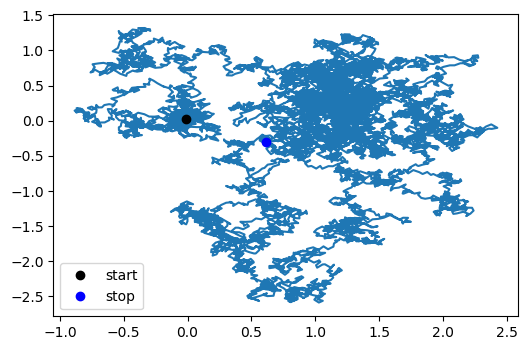

In [11]:
#@title Simulated Velocity Inputs:

def simulate_random_velocity(duration, dt, step_size):
    """
    Inputs
    
    """
    x = step_size * cumsum((random(int(duration/dt)) - 0.5))
    y = step_size * cumsum((random(int(duration/dt)) - 0.5))

    velocity = column_stack((x, y))

    return velocity

step_size = 0.1*metre
dt = 0.1*ms
velocity_array = simulate_random_velocity(duration, dt, step_size)
print(velocity_array)
print()

figure(dpi=100)
plot(velocity_array[:, 0], velocity_array[:, 1])
plot(velocity_array[0, 0], velocity_array[0, 1], 'ro', color='black', label='start')
plot(velocity_array[-1, 0], velocity_array[-1, 1], 'ro', color='blue', label='stop')
legend()



In [12]:
V = TimedArray(velocity_array, dt=dt)

In [17]:
print("Running the simulation")
run(duration)

Running the simulation


BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "C:\Users\divya\anaconda3\lib\site-packages\brian2\core\network.py", line 901, in before_run
    obj.before_run(run_namespace)
  File "C:\Users\divya\anaconda3\lib\site-packages\brian2\groups\neurongroup.py", line 888, in before_run
    self.equations.check_units(self, run_namespace=run_namespace)
  File "C:\Users\divya\anaconda3\lib\site-packages\brian2\equations\equations.py", line 961, in check_units
    all_variables)
  File "C:\Users\divya\anaconda3\lib\site-packages\brian2\equations\unitcheck.py", line 41, in check_dimensions
    expr_dims = parse_expression_dimensions(expression, variables)
  File "C:\Users\divya\anaconda3\lib\site-packages\brian2\parsing\expressions.py", line 327, in parse_expression_dimensions
    right_dim = parse_expression_dimensions(expr.right, variables)
  File "C:\Users\divya\anaconda3\lib\site-packages\brian2\parsing\expressions.py", line 326, in parse_expression_dimensions
    left_dim = parse_expression_dimensions(expr.left, variables)
  File "C:\Users\divya\anaconda3\lib\site-packages\brian2\parsing\expressions.py", line 239, in parse_expression_dimensions
    'a function.' % name)
  File "<string>", line None
SyntaxError: a_plus was used like a variable/constant, but it is a function.

Error encountered with object named "neurongroup_5".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-16-87fb75d3a287>", line 4, in <module>
    P_n = NeuronGroup(N, eqns_exc, threshold='v > 1', reset=reset, method='euler')

An error occurred when preparing an object.   File "<string>", line None

SyntaxError: a_plus was used like a variable/constant, but it is a function.
(See above for original error message and traceback.)

In [43]:

# Simulation order

velocity

NameError: name 'velocity' is not defined